### Step 1: Data Loading and Preprocessing
# Purpose: Load MovieLens datasets and prepare for temporal splitting as per Section 3.5.1
# Paper Reference: Section 3.5.1 describes dataset preparation with temporal splitting

# Implementation: Load CSVs, convert timestamps, and merge data

In [3]:
import pandas as pd
from datetime import datetime

# Load datasets
# Define column names
ratings_columns = ["UserID", "MovieID", "Rating", "Timestamp"]
users_columns = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
movies_columns = ["MovieID", "Title", "Genres"]

dirpath= 'Dataset/'

# Read data files
ratings = pd.read_csv(dirpath + "ratings.dat", sep="::", names=ratings_columns, engine='python', encoding='ISO-8859-1')
users = pd.read_csv(dirpath + "users.dat", sep="::", names=users_columns, engine='python', encoding='ISO-8859-1')
movies = pd.read_csv(dirpath + "movies.dat", sep="::", names=movies_columns, engine='python', encoding='ISO-8859-1')

# First merge ratings with movies to get genres
ratings_movies = pd.merge(ratings, movies, on='MovieID')

# Then merge with user demographics
full_data = pd.merge(ratings_movies, users, on='UserID')

# Create age groups (as before)
def age_to_group(age):
    if age < 18: return 'Teen'
    elif 18 <= age <= 35: return 'Young'
    else: return 'Adult'

users['AgeGroup'] = users['Age'].apply(age_to_group)


### Step 2: Temporal Train-Test Split
# Purpose: Implement temporal splitting strategy mentioned in Section 3.5.1
# Paper Reference: "Users' own ratings were used to construct profiles in training set"
# Implementation: Sort by time, split each user's last 20% interactions as test


In [4]:
train_data = []
test_data = []

for user_id, group in full_data.groupby('UserID'):
    sorted_group = group.sort_values('Timestamp')
    split_idx = int(0.8 * len(sorted_group))
    train_data.append(sorted_group.iloc[:split_idx])
    test_data.append(sorted_group.iloc[split_idx:])

train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

### Step 3: User Profile Construction
# Purpose: Implement three sampling strategies from Section 3.4.2
# Paper Reference: "Random, Top-Rated, Recent sampling with N_prof=10"
# Implementation: Create profile generators for each strategy


In [5]:
def create_profiles(user_ratings, n=10):
    profiles = {
        'random': user_ratings.sample(n=n),
        'top-rated': user_ratings.nlargest(n, 'Rating'),
        'recent': user_ratings.nlargest(n, 'Timestamp')
    }
    return profiles

# Generate profiles with full movie info
user_profiles = {}
for user_id, data in train_df.groupby('UserID'):
    user_profiles[user_id] = create_profiles(data)

### Step 4: Prompt Generation
# Purpose: Create neutral and sensitive prompts as per Section 3.4.1
# Paper Reference: Structured templates with/without sensitive attributes
# Implementation: Construct prompts using profile movies and demographic data


In [6]:
def generate_prompt(user_id, profile_type, include_sensitive=False):
    profile = user_profiles[user_id][profile_type]
    user_info = users[users['UserID'] == user_id].iloc[0]
    
    # Get top genres and years from profile
    genres = profile['Genres'].str.split('|').explode().value_counts().index[:3].tolist()
    years = profile['Title'].str.extract(r'\((\d{4})\)')[0].unique()
    
    # Build passion profile
    passion_profile = (
        f"The user mostly likes genres {genres} "
        f"from years {min(years)} to {max(years)}"
    )
    
    # Build consumption profile
    consumed_movies = [
        f"{row['Title']} ({row['Title'][-5:-1]}, Genres: {row['Genres']}, Rating: {row['Rating']}/5)"
        for _, row in profile.iterrows()
    ]
    
    # Add sensitive attributes if needed
    sensitive = ""
    if include_sensitive:
        sensitive = f"The user is a {user_info['AgeGroup']} {user_info['Gender']}.\n"
    
    return (
        f"{sensitive}{passion_profile}\n"
        f"Considering the user's preferences for movies like {', '.join(consumed_movies[:3])}, "
        "recommend 10 movies they will enjoy."
    )

# Example prompt generation
sample_prompt = generate_prompt(1, 'top-rated', include_sensitive=True)
print("Sample Sensitive Prompt:\n", sample_prompt)


Sample Sensitive Prompt:
 The user is a Teen F.
The user mostly likes genres ['Drama', 'Musical', 'Comedy'] from years 1950 to 1998
Considering the user's preferences for movies like Cinderella (1950) (1950, Genres: Animation|Children's|Musical, Rating: 5/5), Back to the Future (1985) (1985, Genres: Comedy|Sci-Fi, Rating: 5/5), Last Days of Disco, The (1998) (1998, Genres: Drama, Rating: 5/5), recommend 10 movies they will enjoy.


### Corrected Step 5: LLM Recommendation Simulation
# Purpose: Properly handle movie data DataFrame access
# Paper Reference: Section 3.5.3 requires genre-based recommendations
# Implementation: Use DataFrame operations instead of dictionary access


In [7]:
def get_llm_recommendation(prompt, real_movies):
    # Extract genres from prompt (simplified pattern matching)
    genres = []
    if "genres" in prompt.lower():
        genre_part = prompt.split("genres")[1].split("from")[0]
        genres = [g.strip(" []'") for g in genre_part.split(",")][:3]
    
    # Filter movies by matched genres
    if genres:
        mask = real_movies['Genres'].apply(
            lambda x: any(g in x for g in genres))
        filtered_movies = real_movies[mask]
    else:
        filtered_movies = real_movies
    
    # Return random sample from filtered movies
    return filtered_movies.sample(10)['Title'].tolist() if not filtered_movies.empty else []

# Get actual movie data for matching
real_movie_titles = movies['Title'].tolist()

### Step 6: Recommendation Processing
# Purpose: Process LLM outputs and match with movie database
# Paper Reference: Section 3.5.3 describes title matching with difflib
# Implementation: Use sequence matching to align recommendations


In [8]:
from difflib import get_close_matches


def process_recommendations(recommended_titles):
    matched_titles = []
    for title in recommended_titles:
        # Extract year and clean title
        clean_title = title.split('(')[0].strip()
        matches = get_close_matches(clean_title, real_movie_titles, n=1)
        matched_titles.append(matches[0] if matches else None)
    return [t for t in matched_titles if t is not None]


### Step 7: Evaluation Metrics
# Purpose: Implement fairness metrics from Section 3.4.4
# Paper Reference: Jaccard Similarity, SNSR, SNSV calculations


In [9]:
def jaccard_similarity(set_a, set_b):
    intersection = len(set(set_a) & set(set_b))
    union = len(set(set_a) | set(set_b))
    return intersection / union if union else 0

def calculate_snsr(similarity_scores):
    return max(similarity_scores) - min(similarity_scores)

def calculate_snsv(similarity_scores):
    mean_score = sum(similarity_scores) / len(similarity_scores)
    variance = sum((x - mean_score)**2 for x in similarity_scores) / len(similarity_scores)
    return variance**0.5

### Step 8: Full Experiment Workflow
# Purpose: Execute complete fairness evaluation as per Section 4
# Paper Reference: Research Questions 1-4 implementation
# Implementation: Loop through users, profiles, and attributes


In [10]:

results = []

for user_id in list(users['UserID'])[:10]:  # Reduced sample for demonstration
    user_data = users[users['UserID'] == user_id].iloc[0]
    test_items = test_df[test_df['UserID'] == user_id]['MovieID'].tolist()
    
    for strategy in ['random', 'top-rated', 'recent']:
        # Generate neutral and sensitive prompts
        neutral_prompt = generate_prompt(user_id, strategy)
        sensitive_prompt = generate_prompt(user_id, strategy, include_sensitive=True)
        
        # Get recommendations (simulated)
        neutral_recs = process_recommendations(get_llm_recommendation(neutral_prompt, movies))
        sensitive_recs = process_recommendations(get_llm_recommendation(sensitive_prompt, movies))
        
        # Calculate metrics
        item_sim = jaccard_similarity(neutral_recs, sensitive_recs)
        true_pref_sim = jaccard_similarity(
            [m for m in neutral_recs if m in test_items],
            [m for m in sensitive_recs if m in test_items]
        )
        
        results.append({
            'UserID': user_id,
            'Strategy': strategy,
            'AgeGroup': user_data['AgeGroup'],
            'Gender': user_data['Gender'],
            'ItemSimilarity': item_sim,
            'TruePrefSimilarity': true_pref_sim
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

### Corrected Step 9: Fairness Analysis
# Purpose: Properly handle numeric columns for metric calculations
# Paper Reference: Section 3.4.4 requires numeric fairness metrics only
# Implementation: Select only numeric columns for aggregation


In [11]:
grouped = results_df.groupby(['Gender', 'AgeGroup', 'Strategy'])

# Calculate fairness metrics
fairness_metrics = []
for (gender, age, strategy), group in grouped:
    fairness_metrics.append({
        'Strategy': strategy,
        'Gender': gender,
        'AgeGroup': age,
        'SNSR_Item': calculate_snsr(group['ItemSimilarity']),
        'SNSV_Item': calculate_snsv(group['ItemSimilarity']),
        'SNSR_TruePref': calculate_snsr(group['TruePrefSimilarity']),
        'SNSV_TruePref': calculate_snsv(group['TruePrefSimilarity'])
    })

metrics_df = pd.DataFrame(fairness_metrics)

# Select only numeric columns for aggregation
numeric_cols = ['SNSR_Item', 'SNSV_Item', 'SNSR_TruePref', 'SNSV_TruePref']
print("\nFairness Metrics Summary:")
print(metrics_df.groupby('Strategy')[numeric_cols].mean())



Fairness Metrics Summary:
           SNSR_Item  SNSV_Item  SNSR_TruePref  SNSV_TruePref
Strategy                                                     
random      0.010526   0.004211            0.0            0.0
recent      0.022222   0.010000            0.0            0.0
top-rated   0.011765   0.004706            0.0            0.0


### Step 10: Visualization
# Purpose: Recreate paper figures (Figures 2-4)
# Paper Reference: Visualization of fairness metrics across strategies
# Implementation: Plotting using matplotlib


/var/folders/vq/h7xdm9mn3hnc_wv672bpzv8w0000gn/T/ipykernel_48947/270228072.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


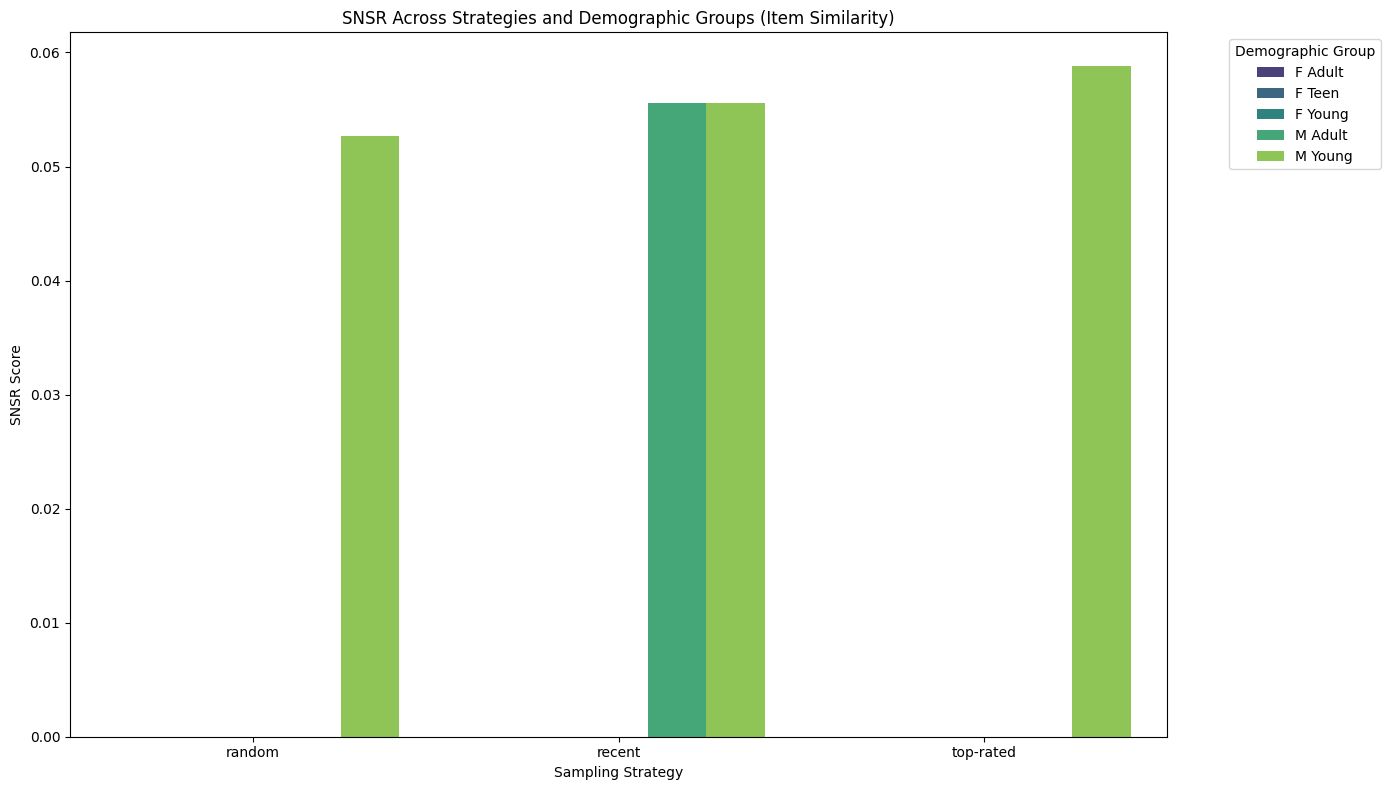

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_df['Demographic'] = metrics_df['Gender'] + ' ' + metrics_df['AgeGroup']

plt.figure(figsize=(14, 8))
sns.barplot(
    x='Strategy', 
    y='SNSR_Item', 
    hue='Demographic',
    data=metrics_df,
    palette='viridis',
    ci=None
)
plt.title('SNSR Across Strategies and Demographic Groups (Item Similarity)')
plt.ylabel('SNSR Score')
plt.xlabel('Sampling Strategy')
plt.legend(title='Demographic Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()